# Feature Engineering, Feature Selection & Exploratory Data Analysis

In this step We're gonna to explore our features in order to create new and more significant features. Besides, We'll look for parterns that may help us to solve the challange and include these parterns in the model.

# 1) Setup

In [1]:
#Libs
import os
import warnings

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv, find_dotenv
from haversine import haversine
from utils.features.stats import check_kruskal_wallis, check_spearman_correlation
from utils.visualization.visualize import cluster_correlation
from utils.features.selection import Boruta 
warnings.filterwarnings('ignore')

In [2]:
# Env variables and data
load_dotenv(find_dotenv())
DATA_INPUT_PATH = os.getenv('DATA_PROCESSED_PATH')
DATA_TRAIN_NAME = 'train'
# Data
df_orders_train = pd.read_parquet(os.path.join(DATA_INPUT_PATH, DATA_TRAIN_NAME))


# 2) Feature Engineering

## 2.1) Time Features

As We have the promised time, We can use information from It as a proxy to the time the order was made. Hence, We are  going to be able to extract hour, day, month, week, and all other characteristics about the time and provide them to the model to learn patterns about It and how those characteristics relates to total minutes.  

In [3]:
# hour of the day
df_orders_train['hour'] = df_orders_train['promised_time'].apply(lambda x: x.hour)
# Create groups to represent different moments of the day
df_orders_train['hour_group'] = 'afternoon'
df_orders_train.loc[df_orders_train['hour'].between(0, 6, inclusive=True), 'hour_group'] = 'dawn'
df_orders_train.loc[df_orders_train['hour'].between(7, 12, inclusive=True), 'hour_group'] = 'morning'
df_orders_train.loc[df_orders_train['hour'].between(18, 23, inclusive=True), 'hour_group'] = 'night'
# day of the week
df_orders_train['day'] = df_orders_train['promised_time'].apply(lambda x: x.dayofweek)
# Create feature is_weekday
df_orders_train['is_weekday'] = 'false'
df_orders_train.loc[df_orders_train['day'].between(0, 4, inclusive=True), 'is_weekday'] = 'true'

## 2.2) Distance

We should calculate distance between store and consumer, so that We can have a clue about the time will take to complete the order.To acomplish this, We'll be using the Harvesine function of sklearn.

In [4]:
df_orders_train['distance_km'] = df_orders_train.apply(lambda x: haversine((x['lat_os'], x['lng_os']), 
                                                                          (x['lat_strb'], x['lng_strb'])), axis=1)

In [5]:
df_orders_train.columns

Index(['order_id', 'lat_os', 'lng_os', 'promised_time', 'on_demand',
       'shopper_id', 'store_branch_id', 'total_minutes', 'seniority',
       'found_rate', 'picking_speed', 'accepted_rate', 'rating', 'store_id',
       'lat_strb', 'lng_strb', 'sum_kgs', 'sum_unities', 'n_distinct_items',
       'hour', 'hour_group', 'day', 'is_weekday', 'distance_km'],
      dtype='object')

Before We proceed, I'll drop unuseful features (those that represent IDs, lat/long and promised time)


In [6]:
df_orders_train.drop(['order_id', 'lat_os', 'lng_os', 'promised_time', 
                      'shopper_id', 'store_branch_id', 'lat_strb', 'lng_strb', 'store_id'], axis=1, inplace=True)

# 3) Exploratory Data Analysis

Let's state some hypothesis and try to check them using statistics and visualization.

In [7]:
df_orders_train.columns

Index(['on_demand', 'total_minutes', 'seniority', 'found_rate',
       'picking_speed', 'accepted_rate', 'rating', 'sum_kgs', 'sum_unities',
       'n_distinct_items', 'hour', 'hour_group', 'day', 'is_weekday',
       'distance_km'],
      dtype='object')

## 3.1) General Questions

- How is total_minutes distributed ?

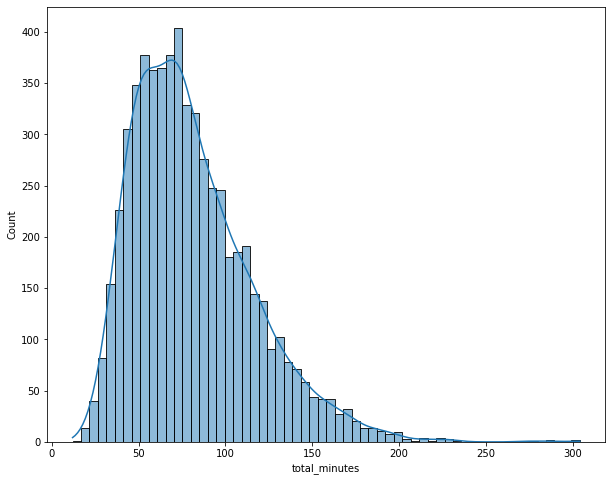

In [8]:
plt.figure(figsize=(10,8))
sns.histplot(df_orders_train['total_minutes'], kde=True)
plt.show()

We see there is a tail starting around 150 minutes. Theses examples can have high influence in our decision surface, so When building the model We'll have to take care of It. We can apply a log transformation, for example, to reduce the impact of these outliers.

In [9]:
df_orders_median_total_minutes_seniority = df_orders_train.groupby('seniority').median()[['total_minutes']].reset_index(level=0)

- How seniority is related to total minutes?

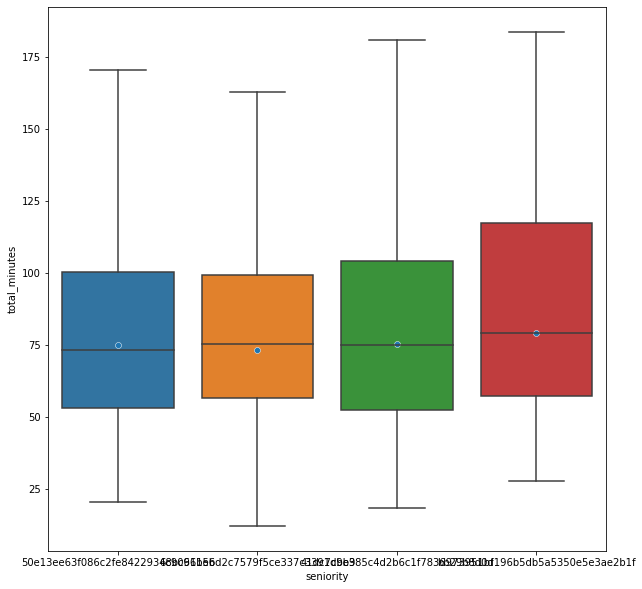

In [10]:
fig = plt.figure(figsize=(10,10))
sns.boxplot(y=df_orders_train['total_minutes'], x=df_orders_train['seniority'], showfliers=False)
sns.scatterplot(x=df_orders_median_total_minutes_seniority['seniority'], y=df_orders_median_total_minutes_seniority['total_minutes'])
plt.show()

It seems there are some subtle differences between median of distributions, though this difference can greater if We include other factors in this analysis, like number of items, distance and etc. To assure there is statistical significance in this result, We're gonna perform a Kruskal Wallis test to test for their medians.

In [11]:
df_orders_train['seniority'].unique()

array(['50e13ee63f086c2fe84229348bc91b5b',
       '6c90661e6d2c7579f5ce337c3391dbb9',
       '41dc7c9e385c4d2b6c1f7836973951bf',
       'bb29b8d0d196b5db5a5350e5e3ae2b1f'], dtype=object)

In [12]:
check_kruskal_wallis(df=df_orders_train, cat_columns=['seniority'], target='total_minutes')

{'seniority': 'not reject'}

- How picking speed is related to total minutes ?

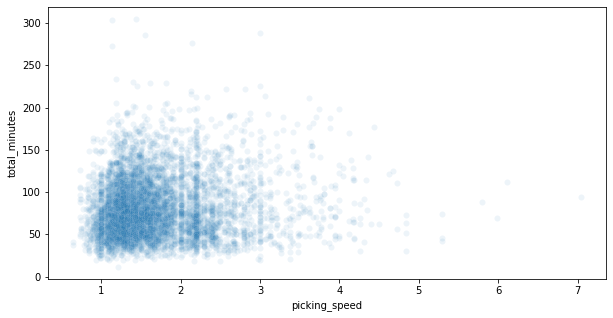

In [13]:
fig = plt.figure(figsize=(10,5))
sns.scatterplot(x=df_orders_train['picking_speed'], 
                y=df_orders_train['total_minutes'],
                alpha=.08)
plt.show()

It seems there is some positive association between picking_speed and total_minutes.

- How days of week and hour relates to the problem?

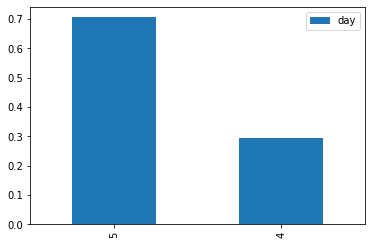

In [14]:
# Let's see the distribution of the days in the week
pd.DataFrame(df_orders_train['day'].value_counts(normalize=True)).plot(kind='bar')
plt.show()

We see that there are only two posible days in the week: 4 and 5, which stands for friday and saturday. About 70% of the orders were made on Friday and 30% on Saturday. We will test if there is some statistical significance in the difference of total minutes for these 2 days, but It would be more helpful if We had a sample comprising all days of the week, so that We could see if the model would learn some seasonal pattern. 

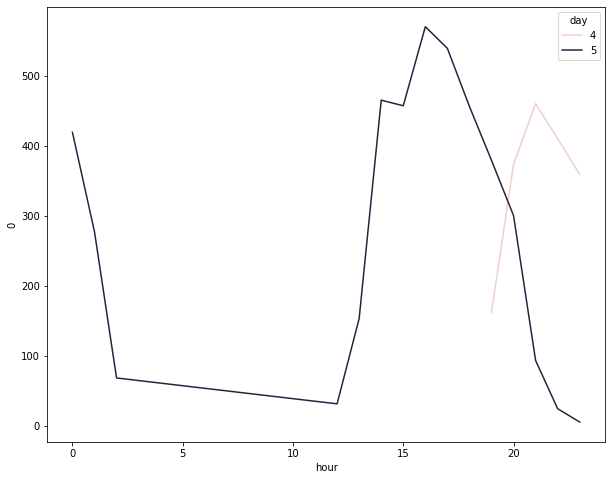

In [15]:
df_size_hour = pd.DataFrame(df_orders_train.groupby(['day','hour']).size()).reset_index(level=0).reset_index()
fig = plt.figure(figsize=(10,8))
sns.lineplot(data=df_size_hour, x="hour", y=0, hue="day")
plt.show()

The days are not even comparable because We don't have a sample which covers all hours of the two days. In day 4 We only have data at night, so there is some bias on this column and We should be aware of this.

Furthermore, the feature `is_weekday` will not be helpful in this case, because It will keep as much information as `day` feature.

- Do orders on demand tend to get faster ? 

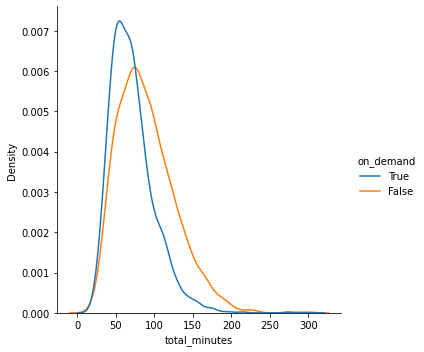

In [16]:
sns.displot(data=df_orders_train, x='total_minutes', hue='on_demand', kind='kde')
plt.show()

If on_demand is a feature assigned independently of day of the week and time, may It be that orders on demand tend to arrive faster.

- How sum_kgs, sum_unities and n_distinct_items relate to total minutes?

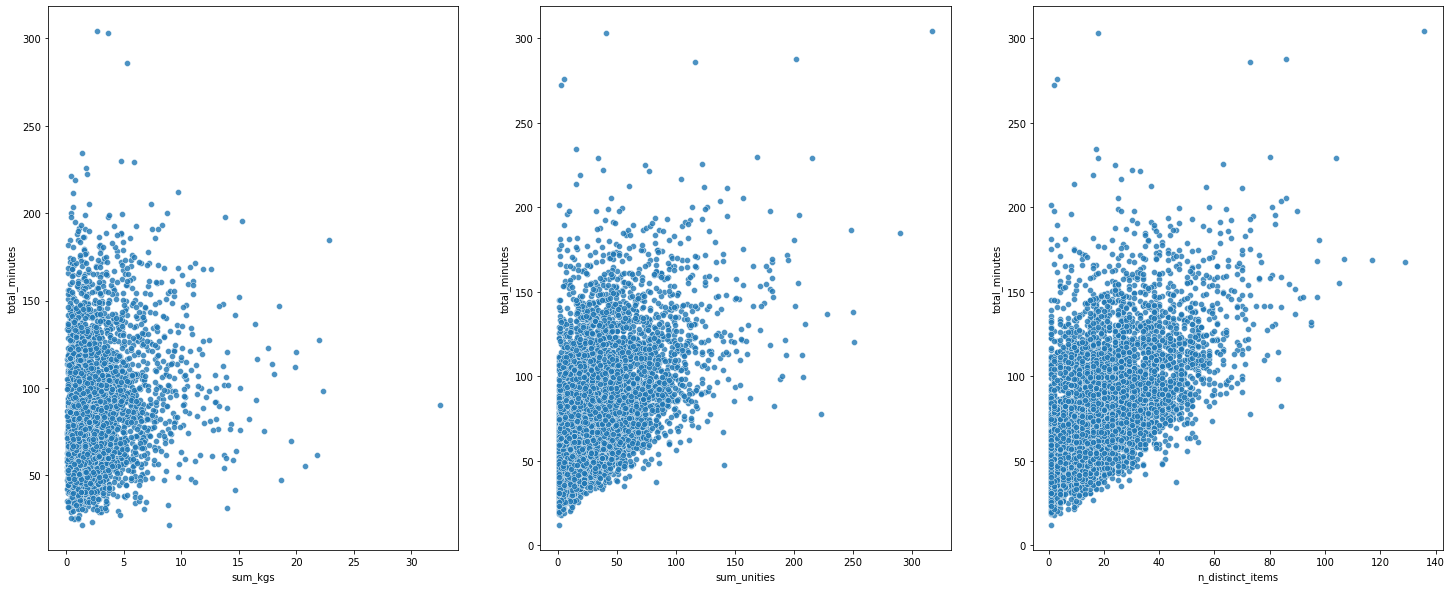

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))
sns.scatterplot(x=df_orders_train['sum_kgs'], 
                y=df_orders_train['total_minutes'],
                alpha=.8,
                palette="YlOrBr",
                ax=axes[0])
sns.scatterplot(x=df_orders_train['sum_unities'], 
                y=df_orders_train['total_minutes'],
                alpha=.8,
                palette="YlOrBr",
                ax=axes[1])   
sns.scatterplot(x=df_orders_train['n_distinct_items'], 
                y=df_orders_train['total_minutes'],
                alpha=.8,
                palette="YlOrBr",
                ax=axes[2])      
plt.show()                                       

In [18]:
df_orders_train['has_both_kgs_unities'] = np.where((df_orders_train['sum_kgs'] > 0) & (df_orders_train['sum_unities'] > 0), 'true', 'false')

- How the distance is related to total minutes ? Is this relationship affect by number of items?

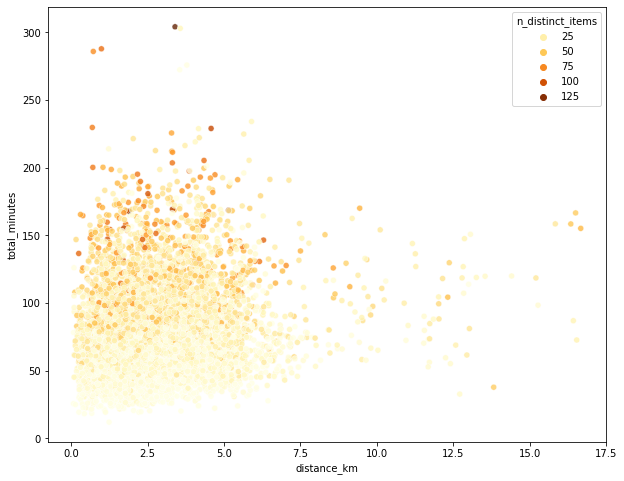

In [19]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(x=df_orders_train['distance_km'], 
                y=df_orders_train['total_minutes'],
                hue=df_orders_train['n_distinct_items'],
                alpha=.8,
                palette="YlOrBr")
plt.show()

It seems that for the same range of `distance_km` We have a very spread distribution of `total_minutes`. If we look more closely, We'll see that the higher values of `total_minutes` occur when the order has higher values of `n_distinct_items`. So, It's not only about the distance, but about how many distinct items the shopper will need to buy.

## 3.2) Correlation 

Let's explore the correlation matrix. As We have few features, the visualization through a heatmap is useful, We should use some more automatic way of evaluating correlation otherwise.

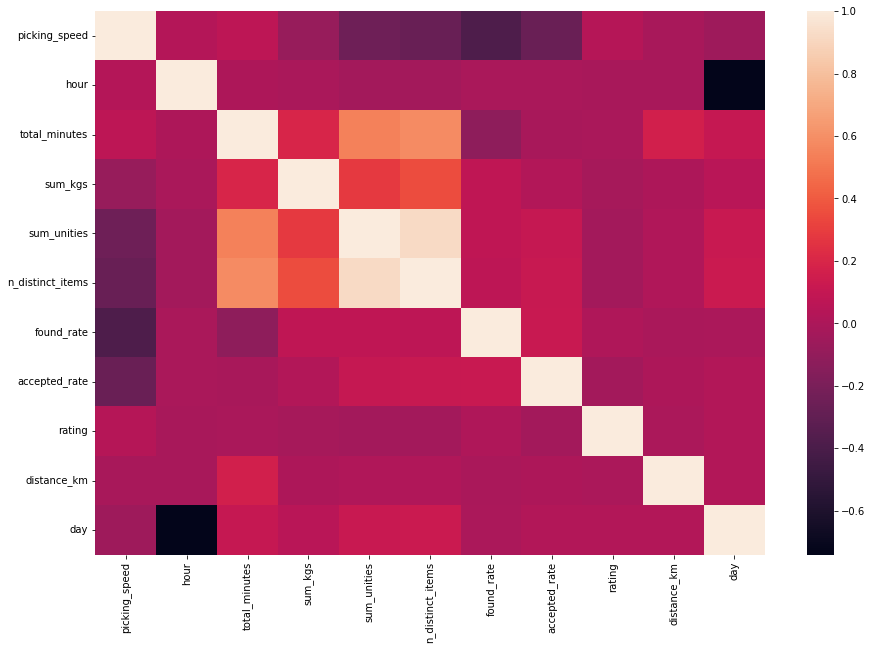

In [20]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(cluster_correlation(df_orders_train.corr(method='spearman')))
plt.show()

In [21]:
df_orders_train.corr(method='spearman')

,total_minutes,found_rate,picking_speed,accepted_rate,rating,sum_kgs,sum_unities,n_distinct_items,hour,day,distance_km
total_minutes,1.000000,-0.117723,0.071883,-0.014529,-0.006160,0.195256,0.539174,0.583295,0.006427,0.107288,0.157047
found_rate,-0.117723,1.000000,-0.385305,0.121077,0.012418,0.081702,0.080246,0.069009,-0.007269,-0.004169,-0.010281
picking_speed,0.071883,-0.385305,1.000000,-0.270510,0.036378,-0.086361,-0.249465,-0.271794,0.034572,-0.060108,-0.015853
accepted_rate,-0.014529,0.121077,-0.270510,1.000000,-0.039876,0.025875,0.108019,0.112885,-0.011240,0.023428,0.001843
rating,-0.006160,0.012418,0.036378,-0.039876,1.000000,-0.023998,-0.039783,-0.033990,-0.016439,0.027194,0.000600
sum_kgs,0.195256,0.081702,-0.086361,0.025875,-0.023998,1.000000,0.285720,0.348534,-0.011826,0.050818,0.002666
sum_unities,0.539174,0.080246,-0.249465,0.108019,-0.039783,0.285720,1.000000,0.922280,-0.034989,0.122604,0.016736
n_distinct_items,0.583295,0.069009,-0.271794,0.112885,-0.033990,0.348534,0.922280,1.000000,-0.038892,0.128114,0.017758
hour,0.006427,-0.007269,0.034572,-0.011240,-0.016439,-0.011826,-0.034989,-0.038892,1.000000,-0.740324,-0.019055
day,0.107288,-0.004169,-0.060108,0.023428,0.027194,0.050818,0.122604,0.128114,-0.740324,1.000000,0.025795


We see the feature `sum_unities` is highly correlated with `n_distinct_items`. At this point We don't know if this can be harmful to our model, but We need to be aware of this and, depending on the model, check if this collinearity affects interpretation of the solution. In case this occurs, We can stick with the
 more correlated with our target, which is `n_distinct_items`.

Month feature is NaN because it is constant. It will be removed in the next step.

# 4) Feature Selection

Initially, let's drop `day` and `is_weekday` as well, because It will case some bias in the model.

In [22]:
df_orders_train.drop(['day', 'is_weekday'], axis=1, inplace=True)

In order to select the best subset of features, We're going to use hypothesis testing to elimante initial features. The remaining features will be used in Boruta Algorithm to define the best subset of features to be used in modeling. 

## 4.1) Hypothesis Testing

As We have a numerical target and a combination of numerical and categorical features, We're going to need two different types of test. 

For numerical features we can use spearman correlation test, which is more robust to outliers and can capture non-linear patterns. And for categorical features We can use Kruskal-wallis test.

In [23]:
df_orders_train.dtypes

on_demand                object
total_minutes           float64
seniority                object
found_rate              float64
picking_speed           float64
accepted_rate           float64
rating                  float64
sum_kgs                 float64
sum_unities             float64
n_distinct_items        float64
hour                      int64
hour_group               object
distance_km             float64
has_both_kgs_unities     object
dtype: object

### 4.1.1) Spearman Correlation Test

- The Null Hypothesis states that the correlation is not different than 0
- The alternative hypothesis states that the correlation is different than 0

In [24]:
num_columns = df_orders_train.select_dtypes(include=['float', 'int']).columns.tolist()
num_columns.remove('total_minutes')
check_spearman_correlation(df_orders_train, num_columns=num_columns, target='total_minutes')

{'found_rate': 'reject',
 'picking_speed': 'reject',
 'accepted_rate': 'not reject',
 'rating': 'not reject',
 'sum_kgs': 'reject',
 'sum_unities': 'reject',
 'n_distinct_items': 'reject',
 'hour': 'not reject',
 'distance_km': 'reject'}

In [25]:
df_orders_train.columns

Index(['on_demand', 'total_minutes', 'seniority', 'found_rate',
       'picking_speed', 'accepted_rate', 'rating', 'sum_kgs', 'sum_unities',
       'n_distinct_items', 'hour', 'hour_group', 'distance_km',
       'has_both_kgs_unities'],
      dtype='object')

Then We're going to remove:
- accepted_rate
- rating
- hour

### 4.1.2) Kruskal-Wallis

In [26]:
# creating a list with all object-type columns
cat_columns = df_orders_train.select_dtypes(include=['O']).columns.tolist()
# performing kruskal-wallis test
check_kruskal_wallis(df_orders_train, cat_columns=cat_columns, target='total_minutes')

{'on_demand': 'reject',
 'seniority': 'not reject',
 'hour_group': 'reject',
 'has_both_kgs_unities': 'reject'}

In [27]:
df_orders_train.drop(['accepted_rate', 'rating', 'hour', 'seniority'], axis=1, inplace=True)

## 4.2) Boruta

Boruta will compare the importances of the features to the importance of the best shadow feature (shuffled versions of original features) n times and then performs a hypothesis test to decide whether reject or keep the features in the dataset.

In [28]:
# Separeting features and target
X_train = df_orders_train.drop('total_minutes', axis=1)
y_train = df_orders_train['total_minutes']

In [32]:
# Boruta 
boruta_selector = Boruta(n_iter=1000)
boruta_selector.fit(X=X_train, y=y_train)

In [36]:
# Features removed by Boruta
boruta_selector._columns_remove_boruta

{'has_both_kgs_unities', 'picking_speed'}

# 5) Exporting 

In [37]:
# Drop unuseful columns
df_orders_train.drop(list(boruta_selector._columns_remove_boruta), axis=1, inplace=True)

In [38]:
df_orders_train.to_parquet(os.path.join(DATA_INPUT_PATH, 'train_best_features'), index=False)